# leave-site-out cross-validation

This notebook will implement a classifier on the ABIDE dataset that predicts autism from resting state fMRI data using leave-site-out cross-validation. This means that each fold contains every site but one, which is then used to measure performance on.

Let's first load the dataset so that we can extract the group information

In [18]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from argparse import ArgumentParser
import numpy as np
from sklearn.decomposition import PCA
import os
import pandas as pd
import time
from requests.exceptions import (
    ChunkedEncodingError,
    RequestException,
    ConnectionError,
    Timeout,
)

In [19]:
from nilearn import datasets
import pandas as pd
#CHANGE PATH (data_dir) TO WERE YOU WANT TO STORE THE DATA

data_dir = "D:/fer/projekt_r/data_dparsf"

abide = datasets.fetch_abide_pcp(data_dir=data_dir,
                                pipeline="dparsf",
                                quality_checked=True)

# Transform phenotypic data into dataframe
abide_pheno = pd.DataFrame(abide.phenotypic)

# Extract group info
groups = []
for s in abide_pheno.SITE_ID:
    # groups.append(s.decode()) # for some reason the site names are of type 'bytes'
    groups.append(s)

In [23]:

def fetch_data_with_retry(data_dir, pipeline, quality_checked, max_retries=5, delay=5):
    for i in range(max_retries):
        try:
            abide = datasets.fetch_abide_pcp(
                data_dir=data_dir,
                pipeline=pipeline,
                quality_checked=quality_checked,
                legacy_format=False,
            )
            return abide
        except (ChunkedEncodingError, RequestException, ConnectionError) as e:
            print(f"Network error occurred: {e}. Retry {i+1} of {max_retries}")
            time.sleep(delay)
        except Timeout as e:
            print(f"Timeout error occurred: {e}. Retry {i+1} of {max_retries}")
            time.sleep(delay)
        except Exception as e:
            print(f"Unknown error occurred: {e}. Retry {i+1} of {max_retries}")
            time.sleep(delay)
    raise Exception("Failed to fetch data after multiple retries")



In [24]:
def prepare_data(data_dir, output_dir, pipeline="cpac", quality_checked=True):
    # get dataset

    print(f"pipeline {pipeline}")
    print("Loading dataset...")
    abide = fetch_data_with_retry(data_dir, pipeline, quality_checked)

    print(f"Downloaded all files")

    # make list of filenames
    fmri_filenames = abide.func_preproc

    # load atlas
    multiscale = datasets.fetch_atlas_basc_multiscale_2015()
    atlas_filename = multiscale.scale064

    # initialize masker object
    masker = NiftiLabelsMasker(
        labels_img=atlas_filename,
        standardize="zscore_sample",
        memory="nilearn_cache",
        verbose=0,
    )

    # initialize correlation measure
    correlation_measure = ConnectivityMeasure(
        kind="correlation",
        vectorize=True,
        discard_diagonal=True,
        standardize="zscore_sample",
    )

    try:  # check if feature file already exists
        # load features
        feat_file = os.path.join(output_dir, "ABIDE_BASC064_features.npz")
        X_features = np.load(feat_file)["a"]
        print("Feature file found.")

    except:  # if not, extract features
        X_features = []  # To contain upper half of matrix as 1d array
        print("No feature file found. Extracting features...")

        for i, sub in enumerate(fmri_filenames):
            # extract the timeseries from the ROIs in the atlas
            time_series = masker.fit_transform(sub)
            print(time_series)
            print(time_series.shape)
            print("------------------------------")
            # create a region x region correlation matrix
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            print(correlation_matrix)
            print(correlation_matrix.shape)
            print("------------------------------")
            # add to our container
            X_features.append(correlation_matrix)
            # keep track of status
            print("finished extracting %s of %s" % (i + 1, len(fmri_filenames)))
        # Save features
        np.savez_compressed(
            os.path.join(output_dir, "ABIDE_BASC064_features"), a=X_features
        )

    print(X_features[0].shape)
    print(len(X_features))
    print(X_features[0])
    print(X_features)
    # Dimensionality reduction of features with PCA
    print("Running PCA...")
    pca = PCA(0.99).fit(X_features)  # keeping 99% of variance
    X_features_pca = pca.transform(X_features)

    # Transform phenotypic data into dataframe
    abide_pheno = pd.DataFrame(abide.phenotypic)

    # Get the target vector
    y_target = abide_pheno["DX_GROUP"]

    return (X_features_pca, y_target)

Next we define how to split our data set. Fortunately, there is a function in scikit-learn that splits data by groups, leaving one group in each iteration, which is exactly what we want here.

We will use the `prepare_data` function from the `prepare_data.py` we wrote to get X and y.

In [25]:
from sklearn.model_selection import LeaveOneGroupOut
import numpy as np
import os

# define data and output directories
# if you already have downloaded the data, provide that directory
# THIS NEEDS TO BE CHANGED IN ORDER TO WORK FOR YOU
# data_dir = os.path.join(os.sep, "mnt", "c", "brainhackschool", "project", "data")
output_dir = data_dir

X, y = prepare_data(data_dir, output_dir, pipeline="dparsf")
y = y.values
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

pipeline dparsf
Loading dataset...
Downloaded all files
No feature file found. Extracting features...
[[ 0.41817847  1.2533721   1.3125703  ...  1.7665322   1.8266464
   1.1999742 ]
 [-0.5393774  -0.4866236  -0.41699582 ...  0.37001365  0.2911363
  -1.1410427 ]
 [-1.7353789  -1.5805478  -0.46794432 ... -0.69693244 -0.5747084
  -1.3870438 ]
 ...
 [-1.5275067  -1.431319   -1.5466709  ... -1.5228481  -1.7530274
  -1.8677359 ]
 [-0.11703643 -1.6477976  -0.7324299  ... -0.6452163  -0.52955556
  -1.7050928 ]
 [-0.52558136 -0.23107666 -1.3555313  ... -0.76197773 -0.12802516
  -0.86990905]]
(195, 64)
------------------------------
[0.7005667  0.39918658 0.40363938 ... 0.6429777  0.60202515 0.6444826 ]
(2016,)
------------------------------
finished extracting 1 of 871
[[-1.5467088  -0.13231432 -0.1650507  ...  0.7014869  -0.41859338
  -1.072676  ]
 [-0.09699716 -0.6600018  -0.71209425 ...  0.29096767 -0.52005684
  -0.9463126 ]
 [ 0.80863154  0.54004323  1.079205   ...  1.0857921   0.38373446
 

KeyboardInterrupt: 

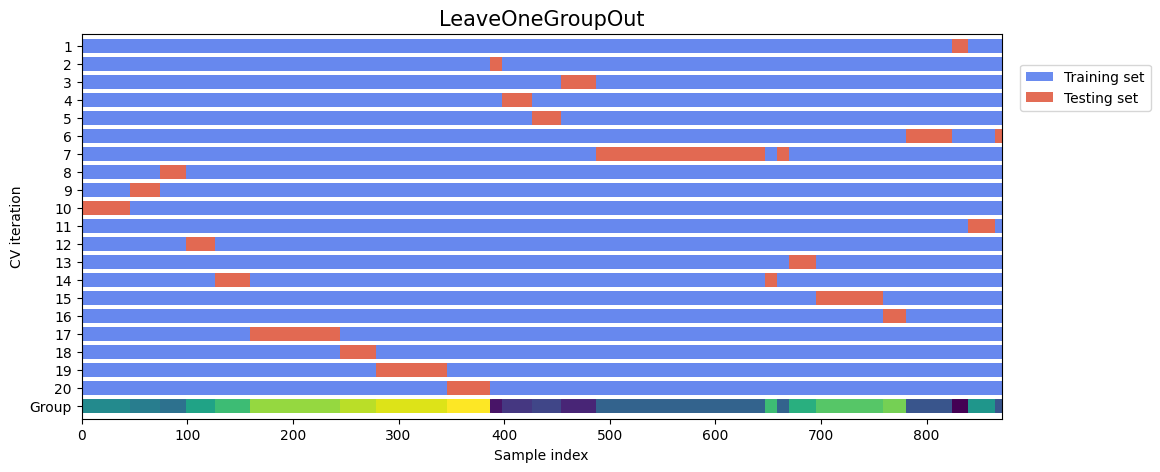

In [4]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_logo_indices(cv, X, y, group, ax, lw=10):
    """Create a sample plot for indices of a LeaveOneGroupOut cross-validation object."""

    le = LabelEncoder()
    group_numeric = le.fit_transform(group)

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # Test instances
        indices[tr] = 0  # Train instances

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap= plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

        # Add the groups to the plot
        ax.scatter(
            range(len(X)),
            [ii+ 1.5] * len(X),
            c=group_numeric,
            marker="_",
            lw=lw,
            cmap='viridis'
        )
    
    # Formatting
    yticks = np.arange(ii + 2) + 0.5
    yticklabels = list(range(1, len(yticks))) +  ["Group"]
    ax.set(
        yticks=yticks,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[ii + 2.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)

    legend_elements = [Patch(facecolor=plt.cm.coolwarm(0.15), label='Training set'),
                       Patch(facecolor=plt.cm.coolwarm(0.85), label='Testing set'),
                       ]

    ax.legend(handles=legend_elements, loc=(1.02, 0.8))
    return ax

    # Usage:
fig, ax = plt.subplots(figsize=(16, 5))
plot_logo_indices(logo, X, y, groups, ax)
fig.subplots_adjust(right=0.7)
plt.show()

Now we define our classifier. The classifier that is going to be used here is going to be a Linear Support Vector Classification (SVC).

In [5]:
from sklearn.svm import LinearSVC

l_svc = LinearSVC(max_iter=10000)

all_accuracies = []

for i, (train_index, test_index) in enumerate(logo.split(X, y, groups)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"Training model {i+1}")
    l_svc.fit(X_train, y_train)
    acc = l_svc.score(X_test, y_test)
    all_accuracies.append(acc)


for i, accuracy in enumerate(all_accuracies):
    print(f"Accuracy for model {i+1}: {accuracy}")

Training model 1


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 2


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 3


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 4


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 5


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 6


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 7


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 8


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 9


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 10


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 11


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 12


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 13


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 14


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 15


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 16


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 17


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 18


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 19


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training model 20


c:\Users\Admin\anaconda3\envs\TEST\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy for model 1: 0.4
Accuracy for model 2: 0.45454545454545453
Accuracy for model 3: 0.5757575757575758
Accuracy for model 4: 0.6071428571428571
Accuracy for model 5: 0.5714285714285714
Accuracy for model 6: 0.43478260869565216
Accuracy for model 7: 0.5872093023255814
Accuracy for model 8: 0.48
Accuracy for model 9: 0.5714285714285714
Accuracy for model 10: 0.56
Accuracy for model 11: 0.5384615384615384
Accuracy for model 12: 0.6666666666666666
Accuracy for model 13: 0.44
Accuracy for model 14: 0.45454545454545453
Accuracy for model 15: 0.625
Accuracy for model 16: 0.5238095238095238
Accuracy for model 17: 0.686046511627907
Accuracy for model 18: 0.6470588235294118
Accuracy for model 19: 0.6268656716417911
Accuracy for model 20: 0.5853658536585366
